# Preparation

 ## Install Related Packages

Note that you have to restart the runtime after all the following installation.

In [1]:
!pip install --upgrade transformers
!pip install --upgrade simpletransformers
!pip install --upgrade rouge-metric

     |████████████████████████████████| 1.3 MB 32.3 MB/s 
     |████████████████████████████████| 9.1 MB 63.1 MB/s 
     |████████████████████████████████| 157 kB 74.6 MB/s 
     |████████████████████████████████| 181 kB 66.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 157 kB 73.8 MB/s 
     |████████████████████████████████| 157 kB 71.4 MB/s 
     |████████████████████████████████| 157 kB 69.5 MB/s 
     |████████████████████████████████| 157 kB 71.9 MB/s 
     |████████████████████████████████| 157 kB 79.5 MB/s 
     |████████████████████████████████| 157 kB 73.2 MB/s 
     |████████████████████████████████| 156 kB 63.5 MB/s 
     |████████████████████████████████| 212 kB 65.0 MB/s 
     |████████████████████████████████| 115 kB 68.5 MB/s 
     |████████████████████████████████| 127 kB 79.0 MB/s 
     |████████████████████████████████| 4.7 MB 52.4 MB/s 
     |████████████████████████████████| 164 kB 68.0 MB/s 
     |██████████

## Mount Your Google Drive for Saving

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Summarization Dataset

In [4]:
# !wget -O CSDS.zip https://www.dropbox.com/s/l157ytg00spu3jq/CSDS.zip?dl=0
!wget -O CSDS.zip https://www.dropbox.com/s/r8e3hda3di7k3lo/CSDS_temp.zip?dl=0
# !cp /content/drive/MyDrive/CSDS.zip /content/CSDS.zip
!unzip CSDS.zip
!rm CSDS.zip

--2022-09-03 07:18:20--  https://www.dropbox.com/s/r8e3hda3di7k3lo/CSDS_temp.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/r8e3hda3di7k3lo/CSDS_temp.zip [following]
--2022-09-03 07:18:21--  https://www.dropbox.com/s/raw/r8e3hda3di7k3lo/CSDS_temp.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc077679325be9a796e979dc8bdd.dl.dropboxusercontent.com/cd/0/inline/BsPMQJwZpesmgggxCn5fsbXWhoGHlgO5AS0kIzGYmjbtDpp0M0v5EBmXmfMCUOQsm0Yjnmcc5XS0YtikGhlCENuhu8EZHUaBTsmxAuChm5kPImqsYzLjxMSzv4p_OZIIG8x2znjP-EZAaywkCpCMXAGAl8mx56luzmZIj3cqs8XSxQ/file# [following]
--2022-09-03 07:18:22--  https://uc077679325be9a796e979dc8bdd.dl.dropboxusercontent.com/cd/0/inline/BsPMQJwZpesmgggxCn5fsbXWhoGHlgO5AS0kIzGYmjbtDpp0M0v5EBmXmfMCUOQsm0Yjn

## Import Packages

In [5]:
import math
import os
import random
import time
import sys

from scipy import spatial
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
from simpletransformers.language_representation import RepresentationModel
from simpletransformers.t5 import T5Model, T5Args
import torch

from rouge_metric import PyRouge
rouge = PyRouge()

# Creation of an mT5 Summarization Model

In [6]:
class T5Summarizer:
    def __init__(self, max_seq_len=500, max_output_len=300, lang='zh'):
        self.max_seq_len = max_seq_len
        self.max_output_len = max_output_len
        self.lang = lang
        self.model = None

    def load_default_model(self, model_path="google/mt5-small"):
        self.model = T5Model("mt5", model_path, use_cuda=True)

    def create_model(self):
        self.model_args = T5Args()
        self.model_args.max_seq_length = self.max_seq_len
        self.model_args.max_length = self.max_output_len
        self.model_args.train_batch_size = 2
        self.model_args.eval_batch_size = 8
        self.model_args.num_train_epochs = 1
        self.model_args.evaluate_during_training = False
        self.model_args.evaluate_during_training_steps = 300000
        self.model_args.use_multiprocessing = False
        self.model_args.fp16 = False
        self.model_args.save_steps = -1
        self.model_args.save_eval_checkpoints = False
        self.model_args.no_cache = True
        self.model_args.reprocess_input_data = True
        self.model_args.overwrite_output_dir = True
        self.model_args.num_return_sequences = 1
        self.model_args.output_dir = "outputs/"
        self.model = T5Model("mt5", "google/mt5-small", args=self.model_args, use_cuda=True)

    def load_data(self, data_type):
        data_dir = "./CLTS"      
        with open(os.path.join(data_dir, "%s.src" % data_type)) as fsrc, open(os.path.join(data_dir, "%s.tgt" % data_type)) as ftgt:
            for src, tgt in zip(fsrc, ftgt):
                src = src.replace(" ", "")[:self.max_seq_len]
                tgt = tgt.replace(" ", "")[:self.max_seq_len]
                yield (src, tgt)

    def train(self, train_size=None):
        torch.cuda.empty_cache()
        torch.cuda.memory_summary(device=None, abbreviated=False)
        self.create_model()
        train_data = []
        for src, tgt in self.load_data("train"):
            train_data.append({"input_text": src, "target_text": tgt})
            if train_size and len(train_data) >= train_size:
                break
        print("Number of training data: %d" % len(train_data))
        train_df = pd.DataFrame(train_data)
        train_df["prefix"] = "summarize"
        self.model.train_model(train_df)

    def evaluate(self, valid_size=None):
        eval_data = []
        references = []
        for src, tgt in self.load_data("test"):
            eval_data.append("summarize: %s" % src)
            if self.lang == 'zh':
                tgt = " ".join(list(tgt))
            references.append([tgt])
            if valid_size and len(eval_data) >= valid_size:
                break
        predictions = self.model.predict(eval_data)
        if self.lang == 'zh':
            predictions = [" ".join(list(p)) for p in predictions]
        print("Number of test data: %d" % len(predictions))
        return rouge.evaluate(predictions, references)

    def perform(self, text, headline="", target_len=None):
        if not self.model:
            self.load_default_model()
        if not target_len:
            target_len = self.max_output_len
        result = self.model.predict(["summarize: %s" % text])[0]
        return result[:target_len]


# Deal with Summarization Dataset (CSDS)

In [ ]:
import json

data_dir = "./CSDS"        
with open(os.path.join(data_dir, "test.json")) as fin:
    raw_data = json.load(fin)
    print("data size:",len(raw_data))
    print(raw_data[0])
    print(raw_data[1])
    print(raw_data[2])

data size: 800
{'DialogueID': 5900, 'QRole': '用户', 'QA': [{'QueSumm': '用户询问改密码除手机验证外的其他方法。', 'AnsSummShort': '客服让用户提供号码，交给专员回电解决。', 'AnsSummLong': '客服让用户提供号码，交给专员回电解决。', 'QueSummUttIDs': [2, 3], 'AnsSummShortUttIDs': [11], 'AnsSummLongUttIDs': [11], 'QASumm': '用户询问改密码除手机验证外的其他方法。客服让用户提供号码，交给专员回电解决。', 'intent': '找回密码'}, {'QueSumm': '用户询问密码登录后，怎样可以不用手机号验证。', 'AnsSummShort': '客服帮助反馈给专员。', 'AnsSummLong': '客服帮助反馈用户的问题给专员。', 'QueSummUttIDs': [21], 'AnsSummShortUttIDs': [23], 'AnsSummLongUttIDs': [21, 23], 'QASumm': '用户询问密码登录后，怎样可以不用手机号验证。客服帮助反馈给专员。', 'intent': '手机邮件相关问题'}, {'QueSumm': '用户询问不验证是否可以买东西。', 'AnsSummShort': '客服请用户耐心等待。', 'AnsSummLong': '客服请用户耐心等待。', 'QueSummUttIDs': [25], 'AnsSummShortUttIDs': [26], 'AnsSummLongUttIDs': [26], 'QASumm': '用户询问不验证是否可以买东西。客服请用户耐心等待。', 'intent': '手机邮件相关问题'}], 'Session_id': 'bb858d8802888c7fd04f509dbf39878d', 'Dialogue': [{'speaker': 'A', 'turn': 0, 'utterance': '有 什么 问题 我 可以 帮 您 处理 或 解决 呢 ?'}, {'speaker': 'Q', 'turn': 1, 'utterance': '你好'}, {'speaker'

In [ ]:
with open(os.path.join(data_dir, "test.json")) as fin:
    raw_data = json.load(fin)
    # print(json.dumps(raw_data[0], indent=4, ensure_ascii=False))
    print(raw_data[0].keys())
    print(raw_data[0]["DialogueID"])
    print(raw_data[1]["DialogueID"])
    print(raw_data[2]["DialogueID"])

dict_keys(['DialogueID', 'QRole', 'QA', 'Session_id', 'Dialogue', 'UserSumm', 'AgentSumm', 'FinalSumm'])
5900
292
5836


In [ ]:
with open(os.path.join(data_dir, "test.json")) as fin:
    raw_data = json.load(fin)
    # [TODO] 每一筆 raw_data 都是是 dict() 的形式，請列出 raw_data[0] 所有的 key 和對應的 value
    # 觀察資料集的資料與投影片第26頁的資料項目描述是否符合（ex: Topic?）
    ##################################################
    for key, value in raw_data[0].items():
      print(key, "=>", value)
    ##################################################

DialogueID => 5900
QRole => 用户
QA => [{'QueSumm': '用户询问改密码除手机验证外的其他方法。', 'AnsSummShort': '客服让用户提供号码，交给专员回电解决。', 'AnsSummLong': '客服让用户提供号码，交给专员回电解决。', 'QueSummUttIDs': [2, 3], 'AnsSummShortUttIDs': [11], 'AnsSummLongUttIDs': [11], 'QASumm': '用户询问改密码除手机验证外的其他方法。客服让用户提供号码，交给专员回电解决。', 'intent': '找回密码'}, {'QueSumm': '用户询问密码登录后，怎样可以不用手机号验证。', 'AnsSummShort': '客服帮助反馈给专员。', 'AnsSummLong': '客服帮助反馈用户的问题给专员。', 'QueSummUttIDs': [21], 'AnsSummShortUttIDs': [23], 'AnsSummLongUttIDs': [21, 23], 'QASumm': '用户询问密码登录后，怎样可以不用手机号验证。客服帮助反馈给专员。', 'intent': '手机邮件相关问题'}, {'QueSumm': '用户询问不验证是否可以买东西。', 'AnsSummShort': '客服请用户耐心等待。', 'AnsSummLong': '客服请用户耐心等待。', 'QueSummUttIDs': [25], 'AnsSummShortUttIDs': [26], 'AnsSummLongUttIDs': [26], 'QASumm': '用户询问不验证是否可以买东西。客服请用户耐心等待。', 'intent': '手机邮件相关问题'}]
Session_id => bb858d8802888c7fd04f509dbf39878d
Dialogue => [{'speaker': 'A', 'turn': 0, 'utterance': '有 什么 问题 我 可以 帮 您 处理 或 解决 呢 ?'}, {'speaker': 'Q', 'turn': 1, 'utterance': '你好'}, {'speaker': 'Q', 'turn': 2, 'utter

In [ ]:
with open(os.path.join(data_dir, "test.json")) as fin:
    raw_data = json.load(fin)
    # [TODO] 請列出 raw_data[0] 中 Dialogue 所有的 speaker 和對應的 utterance
    # 並以 "speaker: utterance" 的形式表示 (ex: A: 有 什么 问题 我 可以 帮 您 处理 或 解决 呢 ?)
    ##################################################
    for utterance in raw_data[0]["Dialogue"]:
        print("%s: %s" % (utterance['speaker'], utterance['utterance']))
    ##################################################

## Preprocessing for Model Input

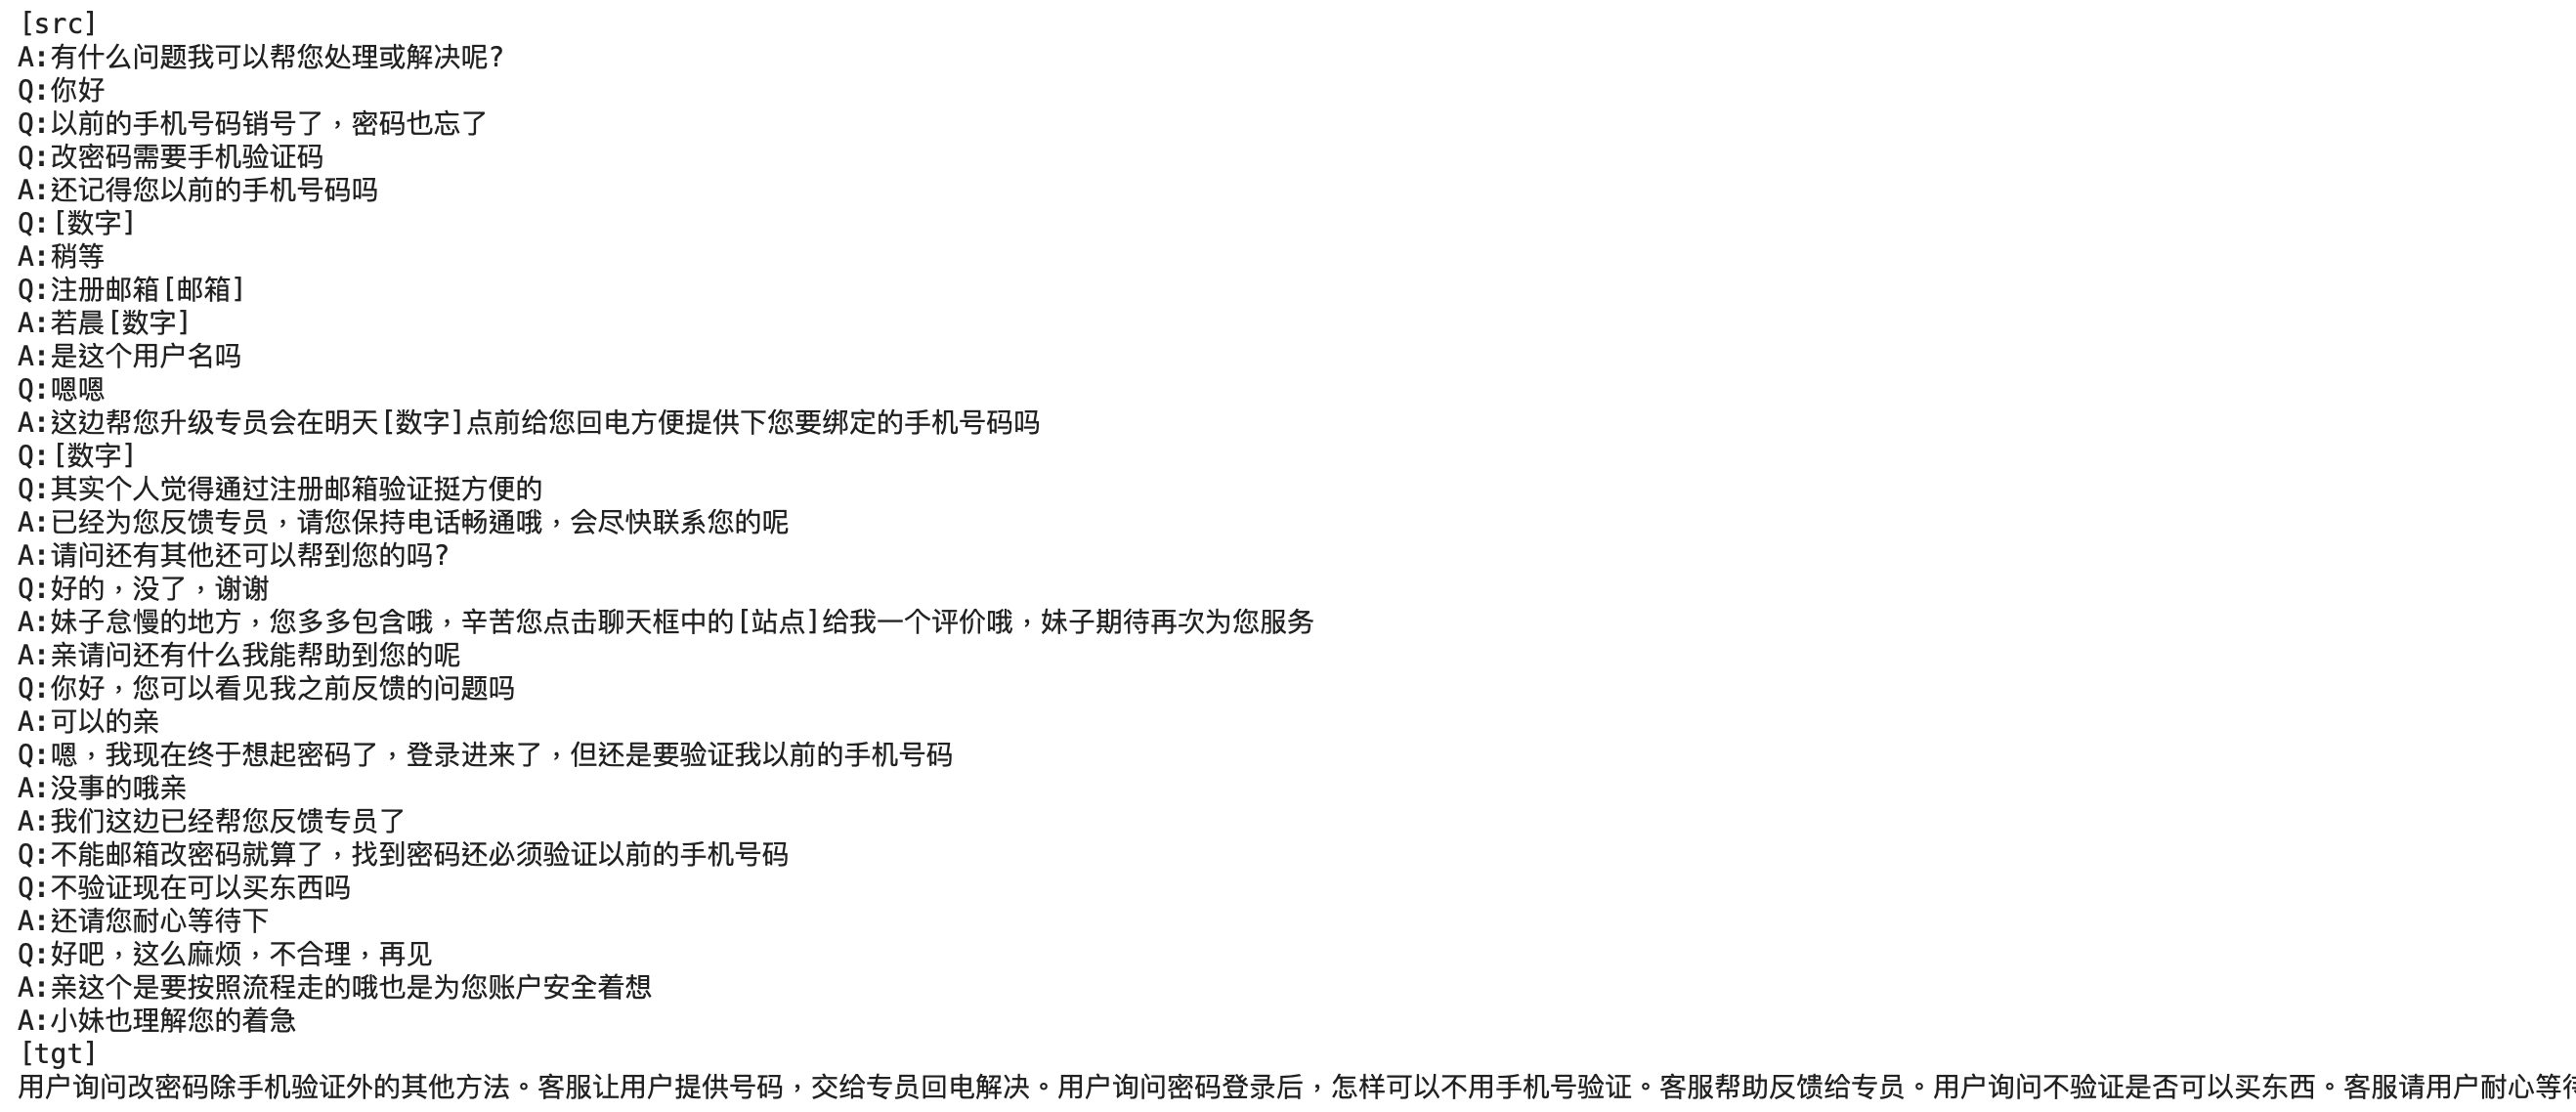

In [ ]:
with open(os.path.join(data_dir, "test.json")) as fin:
    raw_data = json.load(fin)
    for data in raw_data:
        # [TODO] src 是由 Dialogue 中的 speaker 和 utterance 組成，tgt 則是 FinalSumm 組成
        # 請將 src 和 tgt 處理成上圖的樣子
        ##################################################
        src = []
        for utterance in data["Dialogue"]:
            src.append("%s: %s" % (utterance['speaker'], utterance['utterance']))
        src = "\n".join(src).replace(" ", "")
        tgt = "".join(data["FinalSumm"]).replace(" ", "")
        ##################################################
        print("[src]")
        print(src)
        print("[tgt]")
        print(tgt)
        break

# Summarization for Another Domain

In [ ]:
import json

class T5DialogueSummarizer(T5Summarizer):
    def load_data(self, data_type):
        data_dir = "./CSDS"  
        # [TODO] src 是由 Dialogue 中的 speaker 和 utterance 組成，tgt 則是 FinalSumm 組成
        # 請將 src 和 tgt 處理成前面的樣子，並且讓句子的最長長度為self.max_seq_len
        # with open ...
        #     raw_data = ...
        #     for ...
        #         ...
        #         src = ...
        #         tgt = ...
        #         yield (src, tgt)
        ##################################################      
        with open(os.path.join(data_dir, "%s.json" % data_type)) as fin:
            raw_data = json.load(fin)
            for data in raw_data:
                src = []
                for utterance in data["Dialogue"]:
                    src.append("%s: %s" % (utterance['speaker'], utterance['utterance']))
                src = "\n".join(src)
                tgt = "".join(data["FinalSumm"])
                src = src.replace(" ", "")[:self.max_seq_len]
                tgt = tgt.replace(" ", "")[:self.max_seq_len]
                yield (src, tgt)
        ##################################################
    def create_model(self, model_path="google/mt5-small"):
        self.model_args = T5Args()
        self.model_args.max_seq_length = self.max_seq_len
        self.model_args.max_length = self.max_output_len
        # [TODO*] 參考 Simple Transformers 的 Documentation 調整 mT5 的 hyper-parameters 優化效能。
        # （可以嘗試之前投影片提到的 decoding 方法）
        ##################################################
        self.model_args.num_beams = 3
        # self.model_args.do_sample = False
        # self.model_args.top_k = None
        # self.model_args.top_p = None
        # self.model_args.learning_rate = 0.001
        self.model_args.train_batch_size = 2
        self.model_args.eval_batch_size = 8
        self.model_args.num_train_epochs = 1
        self.model_args.evaluate_during_training = False
        self.model_args.evaluate_during_training_steps = 300000
        self.model_args.use_multiprocessing = False
        self.model_args.fp16 = False
        self.model_args.save_steps = -1
        self.model_args.save_eval_checkpoints = False
        self.model_args.no_cache = True
        self.model_args.reprocess_input_data = True
        self.model_args.overwrite_output_dir = True
        self.model_args.num_return_sequences = 1
        ##################################################
        self.model_args.output_dir = "outputs/"
        self.model = T5Model("mt5", model_path, args=self.model_args, use_cuda=True)
        print(self.model_args)


model = T5DialogueSummarizer()
for src, tgt in model.load_data("test"):
    print("[src]")
    print(src)
    print("[tgt]")
    print(tgt)
    break

## Train a Dialogue Summarizatio Model

In [ ]:
model.train()

In [ ]:
model.evaluate()

In [ ]:
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  用户询问改密码除手机验证外的其他方法。客服让用户提供号码，交给专员回电解决。用户询问密码登录后，怎样可以不用手机号验证。客服帮助反馈给专员。用户询问不验证是否可以买东西。客服请用户耐心等待。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: 用户询问为什么手机号码销号,手机号码,密码也忘记了,询问是否可以购买手机验证码。客服回答是用户反馈专员,并告知用户用户手机号码。用户询问是否可以验证东西。客服回答是的。用户询问是否可以购买。客服回答是的。


## Exercise* 

調整 mT5 的 hyper-parameters 優化效能，可以嘗試使用較少筆數的訓練資料來觀察調整（例如僅用前三千筆 ```model.train(3000)``` ）

hyper-parameters 可以參考 Simple Transformers 的 Documentation (https://simpletransformers.ai/docs/usage/ 和 https://simpletransformers.ai/docs/t5-model/)

### Beam Search

* self.model_args.num_beams = 3

In [ ]:
model.create_model("/content/outputs/checkpoint-4551-epoch-1/")

T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_se

In [ ]:
model.evaluate()

Generating outputs:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3579: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/800 [00:00<?, ?it/s]

Number of test data: 800


{'rouge-1': {'r': 0.5022290591892979,
  'p': 0.580150408630455,
  'f': 0.5383849242847635},
 'rouge-2': {'r': 0.35018241661218563,
  'p': 0.40932607862898784,
  'f': 0.37745146050321093},
 'rouge-l': {'r': 0.44025547807374465,
  'p': 0.5057914274558297,
  'f': 0.47075350154127626}}

In [ ]:
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  用户询问改密码除手机验证外的其他方法。客服让用户提供号码，交给专员回电解决。用户询问密码登录后，怎样可以不用手机号验证。客服帮助反馈给专员。用户询问不验证是否可以买东西。客服请用户耐心等待。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: 用户询问手机号码销号,密码也忘了。客服回答已经反馈专员,会在明天[数字]点前给用户回电方便。用户询问为什么不验证现在可以买东西。客服回答是的。


用調整好的參數和全部的資料訓練模型，並評估模型的效能。最後，將訓練好的模型存到 google drive。

In [10]:
!mv /content/outputs/checkpoint-4551-epoch-1/ /content/drive/MyDrive/AI_School/model_dialog/

mv: cannot stat '/content/outputs/checkpoint-4551-epoch-1/': No such file or directory


# Query-based Summarization

## Exercise

Complete the T5DialogueQASummarizer model and evaluate its performance. 

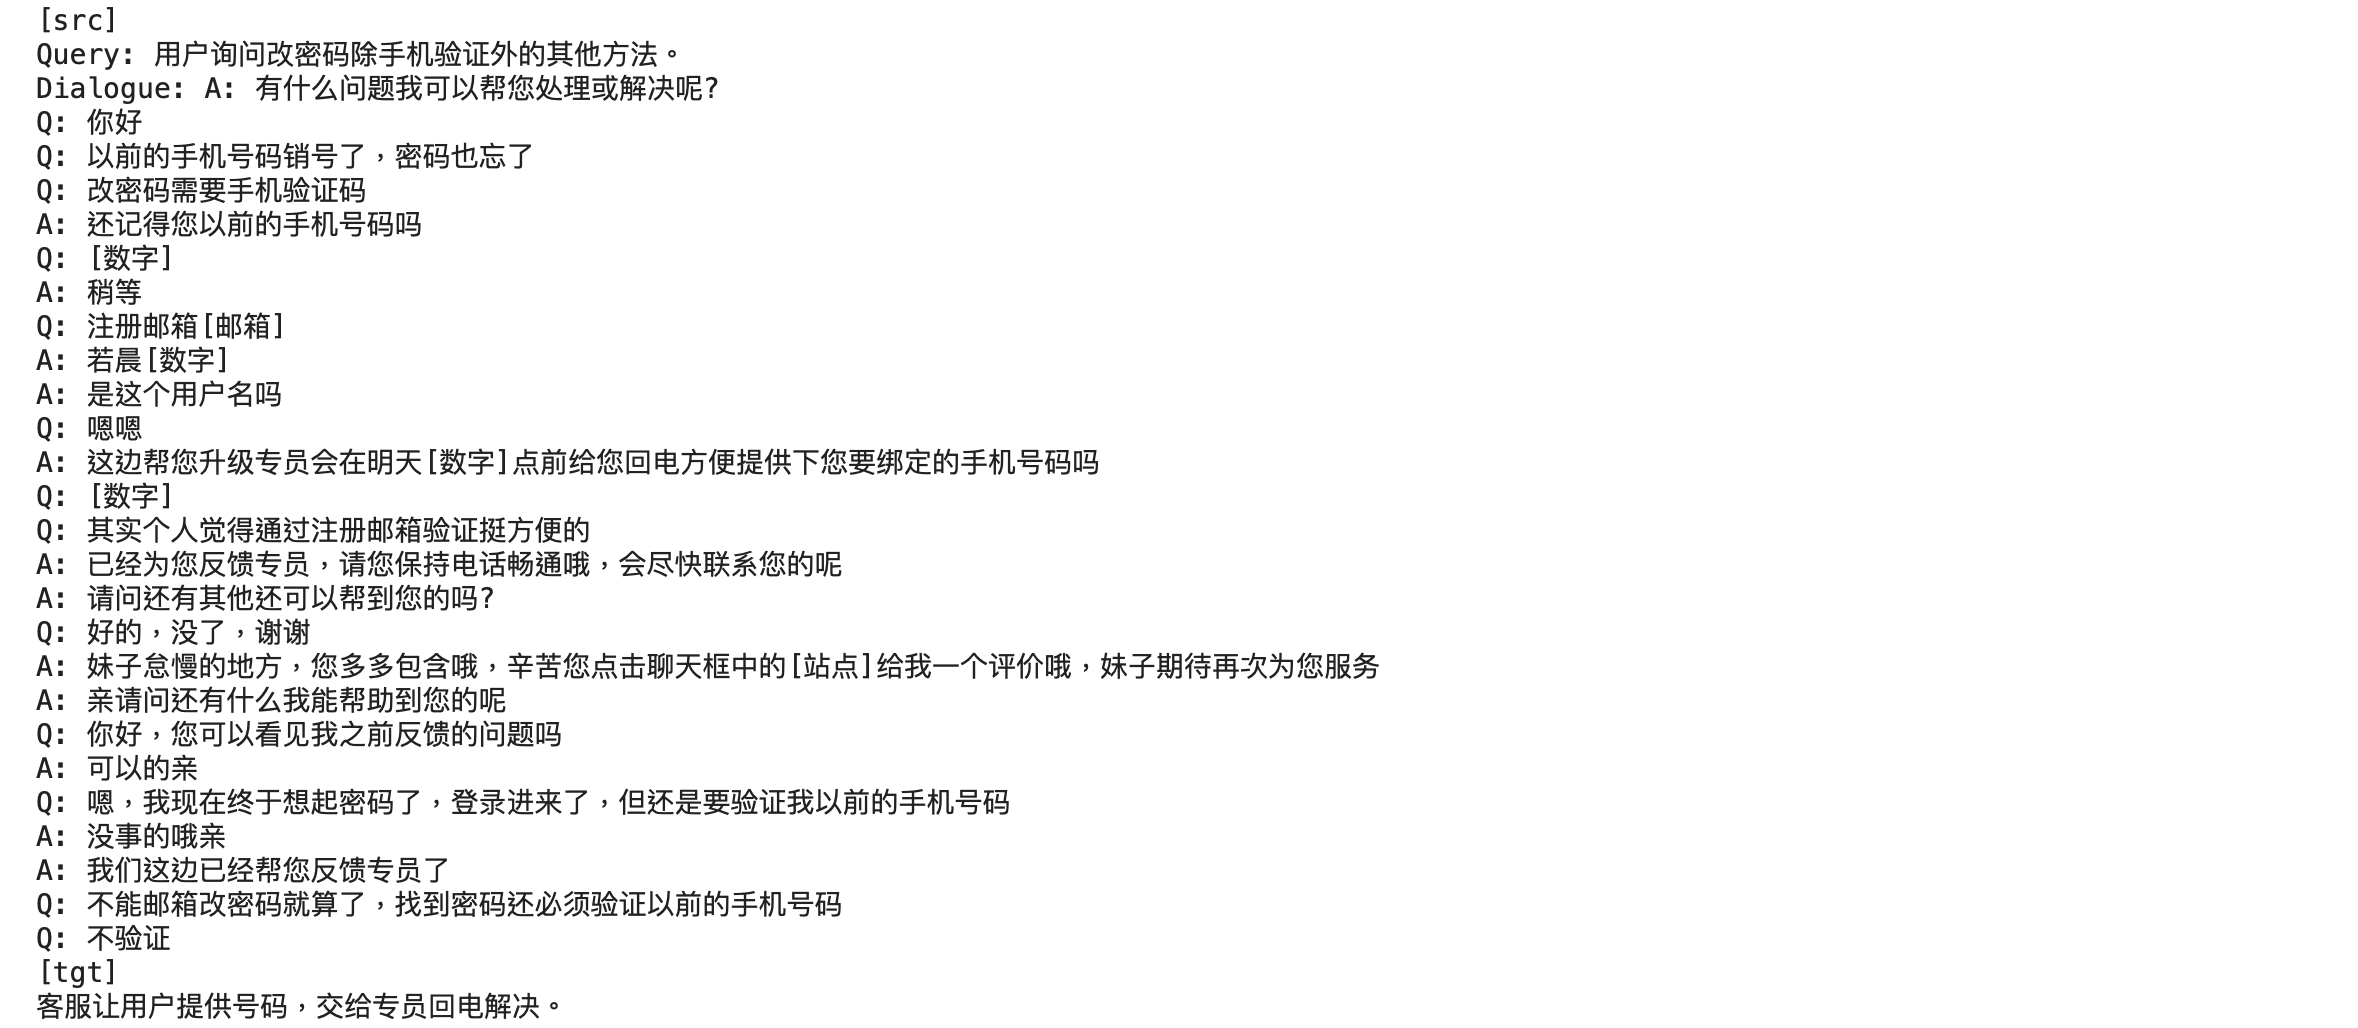

In [8]:
class T5DialogueQASummarizer(T5DialogueSummarizer):
    # [TODO] src 是由 QA 的 QueSumm 加上 Dialogue 中的 speaker 和 utterance 組成，tgt 則是由 QA 的 AnsSummLong 組成
    # NOTE: 一個 QA 可能包含不只一組的 QueSumm 和 AnsSummLong，因此同一 Dialogue 對應不同組的 QueSumm 和 AnsSummLong 是不同的 input example。
    # 也就是說假設某一個 data 的 QA 有兩組 QueSumm 和 AnsSummLong，那這個 data 就會變成兩個不同的 input。
    # 請將 src 和 tgt 處理成前面圖片中的樣子，並且讓句子的最長長度為self.max_seq_len
    # def load_data(self, data_type):
    #    data_dir = "./CSDS"
    #       with open ...
    #          raw_data = ...
    #          for ...
    #             ...
    #             for ...
    #                src = ...
    #                tgt = ...
    #                yield (src, tgt)
    ##################################################
    def load_data(self, data_type):
        data_dir = "./CSDS"        
        with open(os.path.join(data_dir, "%s.json" % data_type)) as fin:
            raw_data = json.load(fin)
            for data in raw_data:
                raw_src = []
                for utterance in data["Dialogue"]:
                    raw_src.append("%s: %s" % (utterance['speaker'], utterance['utterance'].replace(" ", "")))
                raw_src = "\n".join(raw_src)
                for qa in data["QA"]:
                    src = "Query: %s \nDialogue: %s" % (qa["QueSumm"], raw_src)
                    tgt = "".join(qa["AnsSummLong"])
                    src = src[:self.max_seq_len]
                    tgt = tgt[:self.max_seq_len]
                    yield (src, tgt)
    ##################################################


model = T5DialogueQASummarizer()
for src, tgt in model.load_data("test"):
    print("[src]")
    print(src)
    print("[tgt]")
    print(tgt)
    break

[src]
Query: 用户询问改密码除手机验证外的其他方法。 
Dialogue: A: 有什么问题我可以帮您处理或解决呢?
Q: 你好
Q: 以前的手机号码销号了，密码也忘了
Q: 改密码需要手机验证码
A: 还记得您以前的手机号码吗
Q: [数字]
A: 稍等
Q: 注册邮箱[邮箱]
A: 若晨[数字]
A: 是这个用户名吗
Q: 嗯嗯
A: 这边帮您升级专员会在明天[数字]点前给您回电方便提供下您要绑定的手机号码吗
Q: [数字]
Q: 其实个人觉得通过注册邮箱验证挺方便的
A: 已经为您反馈专员，请您保持电话畅通哦，会尽快联系您的呢
A: 请问还有其他还可以帮到您的吗?
Q: 好的，没了，谢谢
A: 妹子怠慢的地方，您多多包含哦，辛苦您点击聊天框中的[站点]给我一个评价哦，妹子期待再次为您服务
A: 亲请问还有什么我能帮助到您的呢
Q: 你好，您可以看见我之前反馈的问题吗
A: 可以的亲
Q: 嗯，我现在终于想起密码了，登录进来了，但还是要验证我以前的手机号码
A: 没事的哦亲
A: 我们这边已经帮您反馈专员了
Q: 不能邮箱改密码就算了，找到密码还必须验证以前的手机号码
Q: 不验证
[tgt]
客服让用户提供号码，交给专员回电解决。


### General Model Training & Evaluation

In [9]:
model.train()

T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_se

  0%|          | 0/18018 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3579: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/9009 [00:00<?, ?it/s]

In [12]:
# 存到自己的雲端硬碟
!mv /content/outputs/checkpoint-9009-epoch-1/ /content/drive/MyDrive/AI_School/model_dialog/

In [ ]:
model.evaluate()

Generating outputs:   0%|          | 0/190 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1517 [00:00<?, ?it/s]

Number of test data: 1517


{'rouge-1': {'r': 0.3911927083123426,
  'p': 0.5218654722426268,
  'f': 0.44717844231395565},
 'rouge-2': {'r': 0.2372182903877424,
  'p': 0.31921804107984364,
  'f': 0.2721761814731387},
 'rouge-l': {'r': 0.37649689852599166,
  'p': 0.5002031266659,
  'f': 0.42962226625120636}}

In [ ]:
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  客服让用户提供号码，交给专员回电解决。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: 客服回答已经帮用户反馈专员,请用户保持电话畅通。


### Zero-shot Learning

*** Method 1 ***

In [ ]:
model.create_model()

T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_se

In [ ]:
model.evaluate()

Generating outputs:   0%|          | 0/190 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1517 [00:00<?, ?it/s]

Number of test data: 1517


{'rouge-1': {'r': 0.05623537045471061,
  'p': 0.07001449003813062,
  'f': 0.0623729922412893},
 'rouge-2': {'r': 0.008272509661162369,
  'p': 0.00706252383451453,
  'f': 0.0076197807679626505},
 'rouge-l': {'r': 0.05542775157925955,
  'p': 0.06915390977214118,
  'f': 0.06153467035205297}}

In [ ]:
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  客服让用户提供号码，交给专员回电解决。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: <extra_id_0>: [数字]


*** Method 2 ***

In [ ]:
model.create_model("./drive/MyDrive/AI_School/model_dialog/")

T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_se

In [ ]:
model.evaluate()

Generating outputs:   0%|          | 0/190 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1517 [00:00<?, ?it/s]

Number of test data: 1517


{'rouge-1': {'r': 0.5895619577322058,
  'p': 0.22385595151563403,
  'f': 0.32449974736258475},
 'rouge-2': {'r': 0.373986851307241,
  'p': 0.13734493479390716,
  'f': 0.20090751681301094},
 'rouge-l': {'r': 0.49364047438453623,
  'p': 0.18434636768553694,
  'f': 0.2684442315060422}}

In [13]:
# 自己train的
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  客服让用户提供号码，交给专员回电解决。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3579: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: 客服回答会升级专员。


In [ ]:
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  客服让用户提供号码，交给专员回电解决。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: 用户询问手机号码销号,密码也忘了。客服回答已经反馈专员会在明天[数字]点前给用户回电方便。


## Homework

使用zero-shot的方法進行預測，並繳交預測結果。

請將預測結果上傳到個人資料夾

In [17]:
model = T5DialogueQASummarizer()
# [TODO] 建立 Zero-Shot 的 model
# (比較前兩種方法選擇比較好的那個)
# model ...
##################################################
model.create_model("./drive/MyDrive/AI_School/model_dialog/")
##################################################


def hand_in():
    data_dir = "./CSDS"
    data_type = "val"
    max_seq_len = 500
    with open(os.path.join(data_dir, "%s.json" % data_type)) as fin, open("task2_xt113015.txt", "w", encoding="utf-8") as fout:
        raw_data = json.load(fin)
        eval_data = []
        for data in raw_data:
            # [TODO] 讀取 val.json 檔，轉成轉成 model input 的形式進行進行predict，
            # 預測結果輸出為task2.txt，請將檔名改為task2_XXX.txt (XXX為學員編號)。
            ##################################################
            raw_src = []
            for utterance in data["Dialogue"]:
                raw_src.append("%s: %s" % (utterance['speaker'], utterance['utterance'].replace(" ", "")))
            raw_src = "\n".join(raw_src)
            for qa in data["QA"]:
                src = "Query: %s \nDialogue: %s" % (qa["QueSumm"], raw_src)
                src = src[:max_seq_len]
            eval_data.append("summarize: %s" % src)
            ##################################################
        predictions = model.model.predict(eval_data)
        if model.lang == 'zh':
            predictions = [" ".join(list(p)) for p in predictions] 
        print("Number of valid data: %d" % len(predictions)) 
        for line in predictions:
            print(line, file=fout)


hand_in()

T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_se

Generating outputs:   0%|          | 0/100 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/800 [00:00<?, ?it/s]

Number of valid data: 800


## Further Exercise*

Try One-shot Learning & Few-shot Learning

In [ ]:
class T5ShotDialogueQASummarizer(T5DialogueQASummarizer):
    def train(self, train_size=None):
        torch.cuda.empty_cache()
        torch.cuda.memory_summary(device=None, abbreviated=False)
        self.create_model("./drive/MyDrive/AI_School/model_dialog/")
        train_data = []
        for src, tgt in self.load_data("train"):
            train_data.append({"input_text": src, "target_text": tgt})
            if train_size and len(train_data) >= train_size:
                break
        print("Number of training data: %d" % len(train_data))
        train_df = pd.DataFrame(train_data)
        train_df["prefix"] = "summarize"
        self.model.train_model(train_df)

    def evaluate(self, valid_size=None):
        eval_data = []
        references = []
        for src, tgt in self.load_data("test"):
            eval_data.append("summarize: %s" % src)
            if self.lang == 'zh':
                tgt = " ".join(list(tgt))
            references.append([tgt])
            if valid_size and len(eval_data) >= valid_size:
                break
        predictions = self.model.predict(eval_data)
        if self.lang == 'zh':
            predictions = [" ".join(list(p)) for p in predictions]
        print("Number of test data: %d" % len(predictions))
        return rouge.evaluate(predictions, references)

    def perform(self, text, headline="", target_len=None):
        if not self.model:
            self.load_default_model()
        if not target_len:
            target_len = self.max_output_len
        result = self.model.predict(["summarize: %s" % text])[0]
        return result[:target_len]

model = T5ShotDialogueQASummarizer()

### One-Shot Learning

In [ ]:
model.train(1)

T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_se

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
model.evaluate()

Generating outputs:   0%|          | 0/190 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1517 [00:00<?, ?it/s]

Number of test data: 1517


{'rouge-1': {'r': 0.5091059067711806,
  'p': 0.2520692039679548,
  'f': 0.33718895650852576},
 'rouge-2': {'r': 0.30356428357668364,
  'p': 0.143863760093232,
  'f': 0.19521306222623927},
 'rouge-l': {'r': 0.42720551258931494,
  'p': 0.2064173586768772,
  'f': 0.2783442249951274}}

In [ ]:
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  客服让用户提供号码，交给专员回电解决。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: 用户询问之前的手机号是否已经退款需要手机验证码。客服回答已经帮忙反馈专员,并告知用户已经帮用户反馈专员,已经帮用户反馈专员。


### Few-Shot Learning

In [ ]:
model.train(10)

T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_se

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
model.evaluate()

Generating outputs:   0%|          | 0/190 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1517 [00:00<?, ?it/s]

Number of test data: 1517


{'rouge-1': {'r': 0.39598857911858626,
  'p': 0.4269683837677687,
  'f': 0.410895371791407},
 'rouge-2': {'r': 0.23191311646373788,
  'p': 0.25005328090631446,
  'f': 0.24064182056426991},
 'rouge-l': {'r': 0.3749868245773935,
  'p': 0.4043811233820894,
  'f': 0.3891296627558312}}

In [ ]:
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  客服让用户提供号码，交给专员回电解决。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: 客服回答帮忙升级专员会在明天[数字]点前给用户回电方便。


## Using Different Prefix

* Prefix => "query summarize"

### Zero-Shot Learning

In [ ]:
model.create_model("./drive/MyDrive/AI_School/model_dialog/")

T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_se

In [18]:
model.evaluate()

Generating outputs:   0%|          | 0/190 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1517 [00:00<?, ?it/s]

Number of test data: 1517


{'rouge-1': {'r': 0.4061002069687133,
  'p': 0.5485725637398541,
  'f': 0.4667053225091281},
 'rouge-2': {'r': 0.2589994549537018,
  'p': 0.35154724926281145,
  'f': 0.2982590695215768},
 'rouge-l': {'r': 0.39534942573866527,
  'p': 0.5325266815925931,
  'f': 0.45379790705826756}}

In [ ]:
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  客服让用户提供号码，交给专员回电解决。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: 用户询问之前的手机号码销号了,密码也忘了。客服回答帮用户升级专员会在明天[数字]点前回电方便提供绑定手机号码。


### One-Shot Learning

In [ ]:
model.train(1)

T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_se

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
model.evaluate()

Generating outputs:   0%|          | 0/190 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1517 [00:00<?, ?it/s]

Number of test data: 1517


{'rouge-1': {'r': 0.4807366160248834,
  'p': 0.28812706328533827,
  'f': 0.3603063406851178},
 'rouge-2': {'r': 0.28022834190177853,
  'p': 0.162690716976133,
  'f': 0.20586402389877784},
 'rouge-l': {'r': 0.39241018497634184,
  'p': 0.22883533562203534,
  'f': 0.2890880123983005}}

In [ ]:
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  客服让用户提供号码，交给专员回电解决。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: 用户询问手机号码后如何修改密码。客服回答已经帮用户升级专员会在明天[数字]点后回电。


### Few-Shot Learning

In [ ]:
model.train(10)

T5Args(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=False, adafactor_scale_parameter=False, adafactor_warmup_init=False, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=300000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=0.001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_se

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
model.evaluate()

Generating outputs:   0%|          | 0/190 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1517 [00:00<?, ?it/s]

Number of test data: 1517


{'rouge-1': {'r': 0.3777012410785984,
  'p': 0.45870194562808125,
  'f': 0.4142793736381407},
 'rouge-2': {'r': 0.22087689963527518,
  'p': 0.27046101404223627,
  'f': 0.24316702860048803},
 'rouge-l': {'r': 0.3626322843214494,
  'p': 0.4410958534628586,
  'f': 0.3980340849753406}}

In [ ]:
for src, tgt in model.load_data("test"):
    print("Target: ", tgt)
    print("Predict:", model.perform(src))
    break

Target:  客服让用户提供号码，交给专员回电解决。


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/1 [00:00<?, ?it/s]

Predict: 客服回答帮忙升级专员会在明天[数字]点点前回电方便。
